
... ***CURRENTLY UNDER DEVELOPMENT*** ...


In [3]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import xarray as xr
np.set_printoptions(precision=3)
import shutil
from datetime import datetime
import matplotlib.pyplot as plt

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..', '..', '..'))

# teslakit
from teslakit.database import Database
from teslakit.climate_emulator import Climate_Emulator

from teslakit.plotting.waves import Plot_Waves_Histogram_FitSim

from teslakit.io.matlab import ReadMatfile


## Database and Site parameters

In [4]:
# --------------------------------------
# Teslakit database
p_data = r'/Users/albacid/Projects/TeslaKit_projects'
site ='ROI'

# set site
db = Database(p_data)
db.SetSite(site)


p_data = r'/Users/albacid/Projects/TeslaKit_projects/sites/' + site + '/'
p_outputs = p_data + 'ClimateChange_SLR_TCs/'

import os
if not os.path.exists(p_outputs):
    os.makedirs(p_outputs)    
    
    
shutil.copytree(p_data + 'EXTREMES/climate_emulator/', p_outputs + 'EXTREMES/climate_emulator/') 

# TODO: remove content of EXTREMES/climate_emulator/Simulations (did it manually)


'/Users/albacid/Projects/TeslaKit_projects/sites/ROI/ClimateChange_SLR_TCs/EXTREMES/climate_emulator/'

In [5]:
# --------------------------------------
# Load data for plotting (waves partitions and families, KMA, DWT)

WVS = db.Load_WAVES_hist()      # Historical gow waves point
KMA = db.Load_ESTELA_KMA()      # ESTELA predictor KMA

# prepare KMA data 
DWTs_fit = xr.Dataset(
    {
        'bmus'       : ('time', KMA['sorted_bmus_storms'].values[:] + 1),
        'cenEOFs'    : (('n_clusters', 'n_features',), KMA['cenEOFs'].values[:]),
    },
    coords = {'time' : KMA['time'].values[:]}
)

# Waves and KMA bmus data share time dimension
WVS_fit = WVS.sel(time = DWTs_fit.time)


# --------------------------------------
# Load data for climate emulator simulation: ESTELA DWT and TCs (MU, TAU) 

DWTs_sim = db.Load_ESTELA_DWT_sim()

TCs_params = db.Load_TCs_r2_sim_params()    # TCs parameters (copula generated) 
TCs_RBFs = db.Load_TCs_sim_r2_rbf_output()  # TCs numerical_IH-RBFs_interpolation output

probs_TCs =  db.Load_TCs_probs_synth()      # TCs synthetic probabilities
pchange_TCs = probs_TCs['category_change_cumsum'].values[:]

l_mutau_wt = db.Load_MU_TAU_hydrograms()   # MU - TAU intradaily hidrographs for each WWT
MU_WT = np.array([x.MU.values[:] for x in l_mutau_wt])  # MU and TAU numpy arrays
TAU_WT = np.array([x.TAU.values[:] for x in l_mutau_wt])


## Obtain future TCs occurence probability 

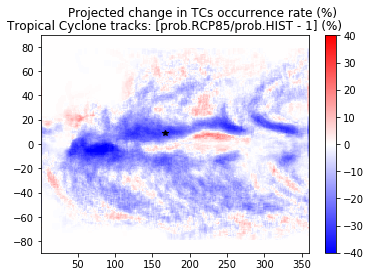

[[8.012e-02 6.101e-02 5.203e-02 2.654e-02 1.035e-02 4.087e-04]
 [8.012e-02 1.191e-01 2.502e-01 2.858e-01 1.771e-01 2.329e-02]
 [8.012e-02 1.191e-01 2.663e-01 3.635e-01 4.012e-01 8.582e-02]
 [8.012e-02 1.191e-01 2.663e-01 3.727e-01 5.494e-01 2.906e-01]
 [8.012e-02 1.191e-01 2.663e-01 3.727e-01 5.633e-01 4.892e-01]
 [8.012e-02 1.191e-01 2.663e-01 3.727e-01 5.633e-01 6.040e-01]]

[-28.832]

[[5.702e-02 4.342e-02 3.703e-02 1.889e-02 7.365e-03 2.908e-04]
 [5.702e-02 8.477e-02 1.781e-01 2.034e-01 1.260e-01 1.658e-02]
 [5.702e-02 8.477e-02 1.895e-01 2.587e-01 2.855e-01 6.108e-02]
 [5.702e-02 8.477e-02 1.895e-01 2.652e-01 3.910e-01 2.068e-01]
 [5.702e-02 8.477e-02 1.895e-01 2.652e-01 4.009e-01 3.481e-01]
 [5.702e-02 8.477e-02 1.895e-01 2.652e-01 4.009e-01 4.299e-01]]


In [6]:
# CMIP5 TCs occurece probability

# ROI
lon = 167.5
lat = 9.75


#--------------------------------------
# 1) read matlab data and select site
file = 'MME_RCP85ratioHIST.mat'

data = ReadMatfile(file)

lon_grid = data['lon'] # lon(0.5,359.5) dlon = 1º # TODO: convertir lon(0,360) a lon(-180,180)
lat_grid = data['lat'] # lat(-89.5,89.5) dlat = 1º
RCP85ratioHIST_occurrence = data['RCP85ratioHIST_occurrence']

lon_grid, lat_grid = np.meshgrid(lon_grid, lat_grid)


# find closest point:
dif_lon = lon_grid - lon
dif_lat = lat_grid - lat
dif = np.sqrt(dif_lon**2 + dif_lat**2)

min_ind = np.where(dif == np.min(dif))
TCs_occurrenceProb = RCP85ratioHIST_occurrence[min_ind[0], min_ind[1]]


# Plot global map and location of Site
plt.pcolor(lon_grid, lat_grid, RCP85ratioHIST_occurrence, cmap='bwr', vmin=-40, vmax=40)
plt.colorbar()
plt.plot(lon_grid[min_ind[0], min_ind[1]], lat_grid[min_ind[0], min_ind[1]], '*k')
plt.title('Tropical Cyclone tracks: [prob.RCP85/prob.HIST - 1] (%)')
plt.suptitle('Projected change in TCs occurrence rate (%)')
plt.show()

print(pchange_TCs)
print()
print(TCs_occurrenceProb)
print()


#--------------------------------------
# Modify future probability of a TC affecting the site (modify probability of TC in r1, entering r2)

pchange_TCs = pchange_TCs + pchange_TCs*TCs_occurrenceProb/100
print(pchange_TCs)

In [5]:
# TODO developer
DWTs_sim = DWTs_sim.isel(n_sim=slice(0, 10))



## Climate Emulator - Fitting

In [7]:
# --------------------------------------
# Climate Emulator extremes model fitting

# climate emulator object
CE = Climate_Emulator(p_outputs + 'EXTREMES/climate_emulator/')

# Load Climate Emulator
CE.Load()


## Climate Emulator - Simulation

In [8]:
# --------------------------------------
#  Climate Emulator simulation

# each DWT series will generate a different set of waves
for n in DWTs_sim.n_sim:
    print('- Sim: {0} -'.format(int(n)+1))
    
    # Select DWTs simulation
    DWTs = DWTs_sim.sel(n_sim=n)

    # Simulate waves
    n_ce = 1  # (one CE sim. for each DWT sim.)
    WVS_sim = CE.Simulate_Waves(DWTs, n_ce, filters={'hs':True, 'tp':True, 'ws':True})

    # Simulate TCs and update simulated waves
    TCs_sim, WVS_upd = CE.Simulate_TCs(DWTs, WVS_sim, TCs_params, TCs_RBFs, pchange_TCs, MU_WT, TAU_WT)
    
    # store simulation data
    CE.SaveSim(WVS_sim, TCs_sim, WVS_upd, int(n))

# WVS_sim, TCs_sim, WVS_upd = CE.LoadSim()    

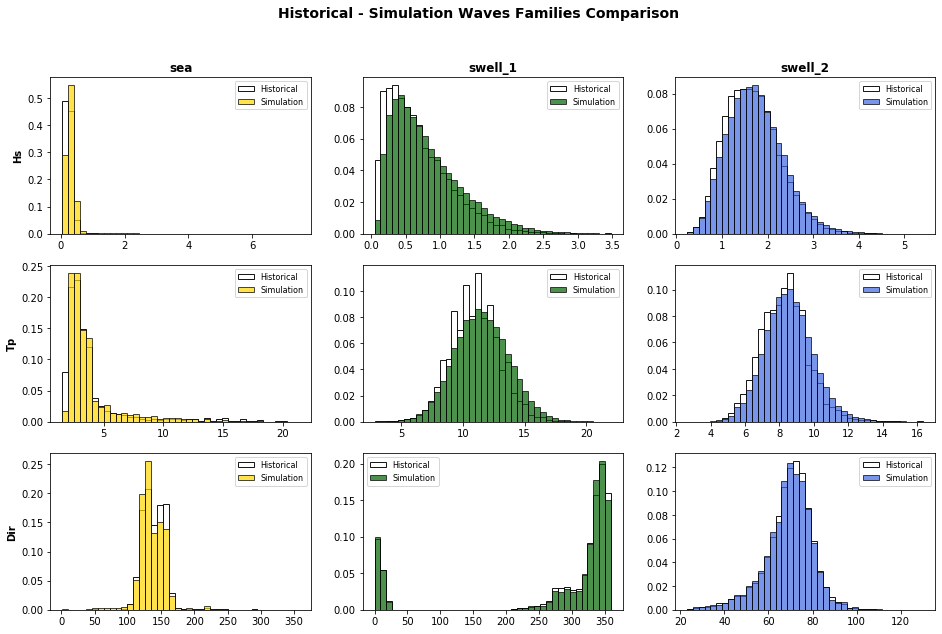

In [9]:
# --------------------------------------
# Select Simulation to plot

# 2 levels of simulation now:
n_sim_DWTs = 0  # switch DWTs Simulation (used at CE Sim.)
n_sim_CE = 0    # switch WAVES Simulation (generated from CE Sim.)

# Load Waves simulated for DWTs set number "n_sim_DWTs"
WVS_sim, TCs_sim, WVS_upd = CE.LoadSim(n_sim = n_sim_DWTs)

# Plot simulated waves parameters distribution 
Plot_Waves_Histogram_FitSim(WVS_fit, WVS_upd.isel(n_sim = n_sim_CE));
